In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_excel('沪深300.xlsx', header=3)
df = df.dropna(axis = 1, how = 'all')

bool_cols = []
for column in df.columns:
    if df[column].dtype == 'bool':
        bool_cols.append(column)
        
df.drop(['tech_MA5', 'tech_MA20'], axis=1, inplace=True)

for column in df.columns:
    if df[column].isnull().any() and column not in bool_cols:
        df[column].fillna(df[column].mean(), inplace=True)
df['trend'] = (df['close'] < df['close'].shift(-1))
df = df.iloc[1:,]
train_size = int(len(df) * 0.8)
y_test = df['trend'].iloc[train_size+20:].values
y_test = y_test.astype(int)

In [5]:
def backtest_strategy(df):
    # Calculate daily returns based on 'close' prices
    df['daily_return'] = df['close'].pct_change()  # Percentage change in close prices
    
    # Initialize strategy returns array
    strategy_returns = []
    for i in range(len(df) - 1):  # Exclude the last row since no next-day action
        if df.loc[i, 'preds'] == 1:
            # If prediction is 1, assume we buy at today's close and sell at tomorrow's close
            strategy_return = (df.loc[i + 1, 'close'] - df.loc[i, 'close']) / df.loc[i, 'close']
        else:
            # If prediction is 0, assume we sell at today's close and buy at tomorrow's close
            strategy_return = (df.loc[i, 'close'] - df.loc[i + 1, 'close']) / df.loc[i, 'close']
        strategy_returns.append(strategy_return)
    
    # Add strategy returns to the DataFrame
    df = df.iloc[:-1]  # Exclude the last row since we can't calculate returns for it
    df['strategy_return'] = strategy_returns
    
    # Calculate cumulative returns for the strategy and index
    df['strategy_net_value'] = (1 + df['strategy_return']).cumprod()
    df['index_net_value'] = (1 + df['daily_return']).cumprod()
    
    # Calculate metrics
    total_days = len(df)
    annualized_return = (df['strategy_net_value'].iloc[-1]) ** (252 / total_days) - 1  # 252 trading days in a year
    daily_win_rate = (df['strategy_return'] > 0).mean()  # Proportion of positive daily returns
    
    df.to_excel('output2.xlsx', index=False)
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['strategy_net_value'], label='Strategy Net Value', color='blue')
    plt.plot(df['date'], df['index_net_value'], label='Index Net Value (510300.SH)', color='orange')
    plt.title('Strategy vs Index Net Value')
    plt.xlabel('Date')
    plt.ylabel('Net Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # print results
    print('Annualized Return:', annualized_return)
    print('Daily Win Rate:', daily_win_rate)
    # Return results
    results = {
        'annualized_return': annualized_return,
        'daily_win_rate': daily_win_rate,
        'strategy_net_value': df['strategy_net_value'],
        'index_net_value': df['index_net_value']
    }
    return results

Evaluation of the ensemble model:
Accuracy: 0.5273
Precision: 0.4797
Recall: 0.7472
F1 Score: 0.5843


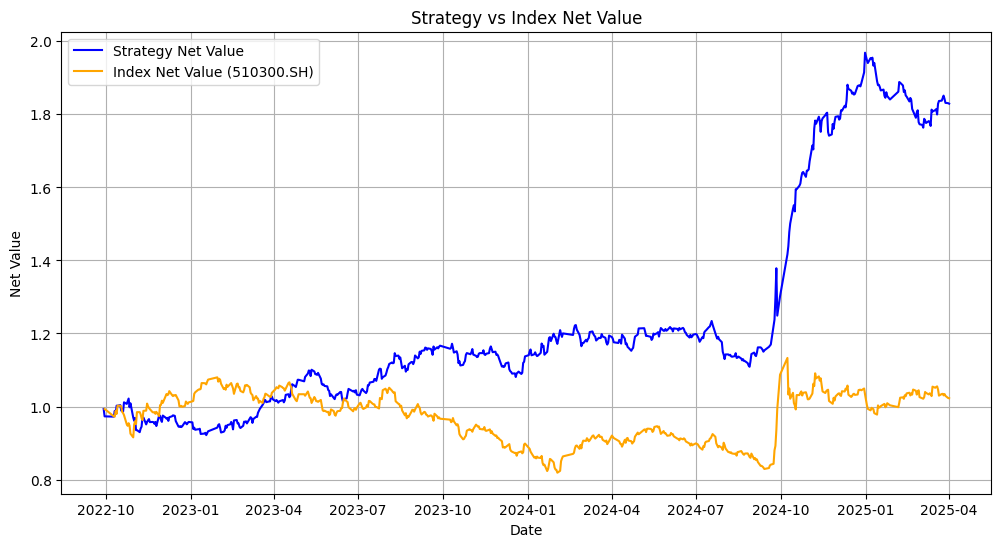

Annualized Return: 0.2865267735363519
Daily Win Rate: 0.5215231788079471



In [6]:
transformer_test_preds = np.load("transformer_prob_preds.npy")
vae_test_preds = np.load("vae_prob_preds.npy")
xgboost_test_preds = np.load("xgboost_prob_preds.npy")

transformer_test_preds = transformer_test_preds.reshape(-1, 1) 
vae_test_preds = vae_test_preds.reshape(-1, 1) 
xgboost_test_preds = xgboost_test_preds.reshape(-1, 1) 

# weights
w_transformer = 0.1 
w_vae = 0.2          
w_xgboost = 0.7      

# apply weights to the predictions
final_prob_preds = (
    w_transformer * transformer_test_preds +
    w_vae * vae_test_preds +
    w_xgboost * xgboost_test_preds
)

final_preds = (final_prob_preds >= 0.5).astype(int)

# evaluation
accuracy = accuracy_score(y_test, final_preds)
precision = precision_score(y_test, final_preds)
recall = recall_score(y_test, final_preds)
f1 = f1_score(y_test, final_preds)

print("Evaluation of the ensemble model:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

ensemble_backtest = df.loc[train_size+20+1:, ['Date', 'close']]
ensemble_backtest['preds'] = final_preds
ensemble_backtest.rename(columns={'Date':'date'}, inplace=True)
ensemble_backtest.reset_index(drop=True, inplace=True)
ensemble_backtest.to_excel('ensemble_output.xlsx', index=False)
backtest_strategy(ensemble_backtest)
print()